This notebook loads data from a ship roll decay test simulation and tries to predict the parameters in a matematical model describing the dynamics of this system. If you are not familiar with the ship roll decay test, you can check out this 
[Video](https://youtu.be/gN123b8gM-o).

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import sympy as sp
import sympy.physics.mechanics as me
from sympy.physics.vector.printing import vlatex
from IPython.display import Math
import statsmodels.api as sm
from sklearn.metrics import r2_score
from scipy.integrate import solve_ivp
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 462 ('figure.figsize   : 5, 3   ## figure size in inches')
Duplicate key in file WindowsPath('C:/Users/maa/.matplotlib/stylelib/paper.mplstyle'), line 463 ('figure.dpi       : 100        ## figure dots per inch')


# Loading data from the simulation
The present dataset contains roll decay tests from actual model tests, carried out at [SSPA maritime-dynamics-laboratory](https://www.sspa.se/our-facilities-and-tools/maritime-dynamics-laboratory) and also CFD simulations, using a method called FNPF. A parameter identification of the data from the FNPF simulation at 0 knots is described below.

In [2]:
data = pd.read_csv('../data/external/fnpf_kvlcc2_rolldecay_0kn.csv', index_col=0)

This file contains time series for roll angle: $\phi$ (**phi**) and its first and second time derivatives $\dot{\phi}$ (**phi1d**) and $\ddot{\phi}$ (**phi2d**).

In [3]:
data.head()

,phi,phi1d,phi2d,V1
Time,,,,
0.02,0.174388,-0.018087,-1.091653,3.082352e-11
0.04,0.173809,-0.039806,-1.082627,-3.701665e-05
0.06,0.172796,-0.061389,-1.074681,-7.304180e-05
0.08,0.171354,-0.082849,-1.065540,-1.121690e-04
0.10,0.169484,-0.104042,-1.056223,-1.409602e-04


The ship is forces into an initial roll angle at the start of the test. When the ship is released it starts an oscillation motion that is decaying over time, due to the hydrodynamic roll damping of the ship. The time series of the roll angle of the ship is shown in the figure below:

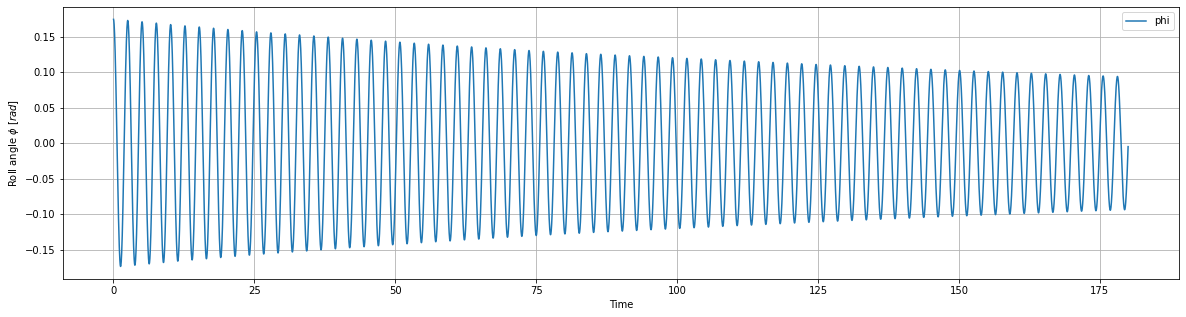

In [4]:
fig,ax=plt.subplots()
fig.set_size_inches(20,5)
data.plot(y='phi', ax=ax);
ax.set_ylabel(r'Roll angle $\phi$ $[rad]$')
ax.grid(True)

The ship is now behaving very much like the classical spring-mass-damper system in dynamics:

![spring](https://upload.wikimedia.org/wikipedia/commons/thumb/4/45/Mass_spring_damper.svg/220px-Mass_spring_damper.svg.png)

This system can be described by the following differential equation:

In [5]:
phi = me.dynamicsymbols('phi')  # Roll angle
phi_dot = phi.diff()
phi_dot_dot = phi_dot.diff()

A_44 = sp.symbols('A_44')  # description='Total mass moment of inertia', unit='kg*m**2'
B_44 = sp.Function('B_{44}')(phi_dot)
C_44 = sp.Function('C_{44}')(phi)

lhs = A_44*phi_dot_dot + B_44 + C_44
rhs = 0
roll_equation_himeno = sp.Eq(lhs=lhs, rhs=rhs)
Math(vlatex(roll_equation_himeno))

<IPython.core.display.Math object>

where $A_{44}$ is the total roll intertia (representing the mass $m$), $B_{44}(\dot{\phi})$ is a function for the roll damping ($c$ in the figure above) and $C_{44}(\phi)$ is the stiffness (represented by the spring force $k$ in the figure). The $A_{44}=1$ is assumed to give this equation one unique solution. The equation is now ritten as:

In [6]:
roll_equation_normalized = roll_equation_himeno.subs(A_44,1)
Math(vlatex(roll_equation_normalized))

<IPython.core.display.Math object>

## Stiffness model
The following polynomial will be used for the stiffness model:

In [7]:
C_1, C_3, C_5 = sp.symbols('C_1 C_3 C_5')
restoring_equation_cubic = sp.Eq(C_44, C_1 * phi + C_3 * phi ** 3 + C_5 * phi ** 5)
restoring_equation_cubic

Eq(C_{44}(phi(t)), C_1*phi(t) + C_3*phi(t)**3 + C_5*phi(t)**5)

## Damping model
The following polynomial will be used for the damping model:

In [8]:
B_1, B_2, B_3 = sp.symbols('B_1 B_2 B_3')
b44_cubic_equation = sp.Eq(B_44, B_1 * phi_dot + B_2 * phi_dot * sp.Abs(phi_dot) + B_3 * phi_dot ** 3)
Math(vlatex(b44_cubic_equation))

<IPython.core.display.Math object>

The model can now be rewritten with these polynomials:

In [9]:
roll_decay_equation_cubic = roll_equation_normalized.subs([
    (C_44, restoring_equation_cubic.rhs),
    (B_44, b44_cubic_equation.rhs),
    
])
Math(vlatex(roll_decay_equation_cubic))

<IPython.core.display.Math object>

# Regression
The parameters of this model  $B_1$, $B_2$, $C_1$..., can now be indentified using regression of the time series. The linear regression is expressed as:
$$ y = X \cdot \beta + \epsilon $$

where:
* $y$ is the dependent variable (also called *label*). 
* $\beta$ is a vector with the regressed parameters.
* $X$ is a matrix containing the independent variables (also called *features*).

The roll decay equation can be expressed as a linear regression with
* $y$ : the roll angle acceleration $\ddot{\phi}$ 
* $\beta$ : contains all the parameters : $B_1$, $B_2$, $C_1$...
* $X$ : contains all the time varying features such as: $| \dot{\phi} | \dot{\phi} $ etc.

In [10]:
acceleration_equation_cubic = sp.Eq(phi_dot_dot,
      sp.solve(roll_decay_equation_cubic, phi_dot_dot)[0])

Math(vlatex(acceleration_equation_cubic))

<IPython.core.display.Math object>

In [11]:
def calculate_features(data):
    phi=data['phi']
    phi1d=data['phi1d']
    data_features = -np.array([phi1d, np.abs(phi1d)*phi1d, phi1d**3, phi, phi**3, phi**5]).T
    return data_features

def generate_features_and_label(data, calculate_features=calculate_features, columns = ['B_1','B_2','B_3','C_1','C_3','C_5']):
    
    data_features = calculate_features(data=data)
    
    X = pd.DataFrame(data=data_features, index=data.index, columns=columns)
    
    y = data['phi2d']
    
    return X,y

In [12]:
X,y = generate_features_and_label(data=data)

## Linear regression
The parameters in the linear regression can now be determined with ordinary least square fit:

In [13]:
model = sm.OLS(y,X)
results = model.fit()

In [14]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  phi2d   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.053e+08
Date:                Mon, 31 May 2021   Prob (F-statistic):                        0.00
Time:                        13:47:12   Log-Likelihood:                          42714.
No. Observations:                9000   AIC:                                 -8.542e+04
Df Residuals:                    8994   BIC:                                 -8.537e+04
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B_1            0.0163      0.001     16.878      0.000       0.014       0.018
B_2           -0.0617      0.007     -8.508      0.000      -0.076      -0.047
B_3            0.0981      0.013      7.444      0.000       0.072       0.124
C_1            6.1162      0.001   6055.181      0.000       6.114       6.118
C_3           -5.5215      0.146    -37.941      0.000      -5.807      -5.236
C_5          254.0934      4.678     54.312      0.000     244.923     263.264
==============================================================================
Omnibus:                      496.814   Durbin-Watson:                   1.632
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1895.581
Skew:                           0.126   Prob(JB):                         0.00
Kurtosis:                       5.234   Cond. No.                     4.97e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.97e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

A comparison of roll acceleration predicted with this model show very good agreement with the original data:

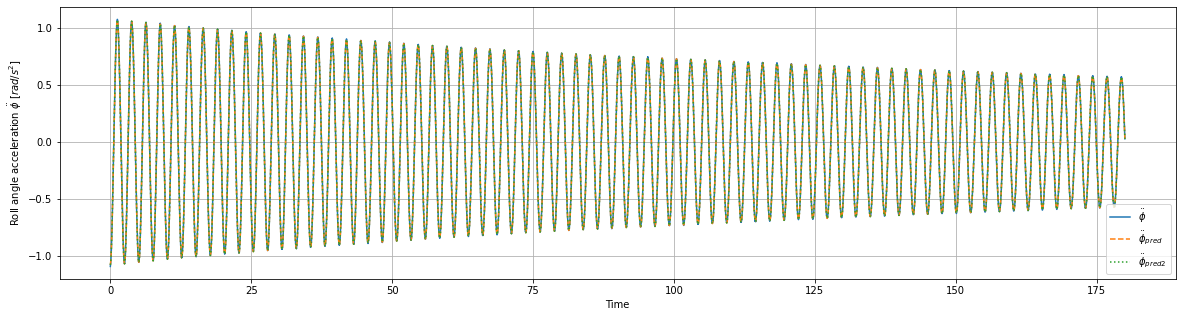

In [15]:
y_pred = results.predict(X)

fig,ax=plt.subplots()
fig.set_size_inches(20,5)
data.plot(y='phi2d', ax=ax, label=r'$\ddot{\phi}$');

ax.plot(data.index, y_pred, '--', label=r'$\ddot{\phi}_{pred}$')
ax.plot(data.index, y_pred, ':', label=r'$\ddot{\phi}_{pred2}$')

ax.set_ylabel(r'Roll angle acceleration $\ddot{\phi}$ $[rad/s^2]$')

ax.grid(True)
ax.legend();

## Simulate
The regressed parameters can also be used to make simulation of the roll angle time series, solving the initial value problem using time step simulations.

In [16]:
def get_updater(results, calculate_features=calculate_features):
    
    def updater(t, states):
        phi = states[0]
        phi1d = states[1]
            
        s = {
            'phi':phi,
            'phi1d':phi1d
        }
        
        x = calculate_features(data=s)
        phi2d = results.predict(x)[0]
            
        d_states_dt = np.array([phi1d, phi2d])
        return d_states_dt
    
    return updater

y0 = [data.iloc[0]['phi'],
      data.iloc[0]['phi1d'],
     ]
t = data.index
t_span = [t[0], t[-1]]
updater = get_updater(results=results)
result = solve_ivp(fun=updater, t_span=t_span, y0=y0, t_eval=t)
df_result = pd.DataFrame(index=result.t, data=result.y.T, columns = ['phi','phi1d'])

The figure below shows a comparison between a simulated roll angle time series and the actual roll signal from the FNPF dataset.

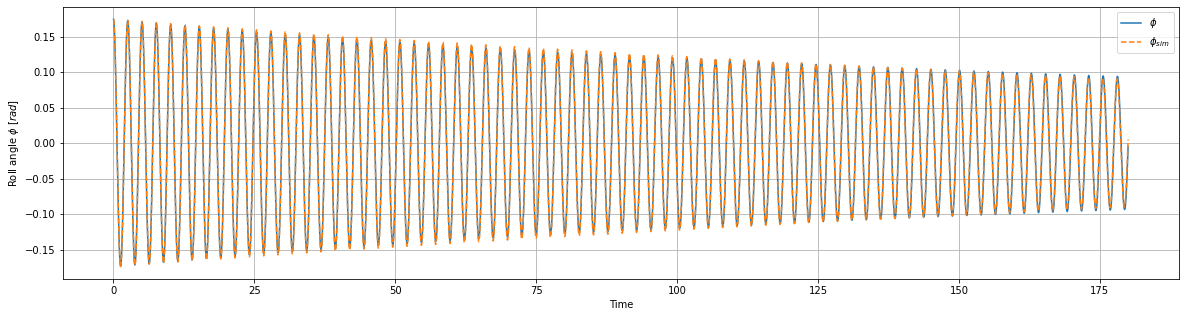

In [17]:
fig,ax=plt.subplots()
fig.set_size_inches(20,5)
data.plot(y='phi', ax=ax, label=r'$\phi$');

df_result.plot(y='phi', style='--', label=r'$\phi_{sim}$', ax=ax)

ax.set_ylabel(r'Roll angle $\phi$ $[rad]$')

ax.grid(True)
ax.legend();

The coefficient of determination $R^2$ calculated on the roll signal is:

In [18]:
r2_score(y_true=data['phi'], y_pred=df_result['phi'])

0.9970937348398604

## Simpler model
Perhaps the model can be simplified, using only the linear damping term $B_1$

In [19]:
acceleration_equation_linear = acceleration_equation_cubic.subs([
    (B_2,0),
    (B_3,0),
])

Math(vlatex(acceleration_equation_linear))

<IPython.core.display.Math object>

In [20]:
def calculate_features_simple(data):

    phi=data['phi']
    phi1d=data['phi1d']
    data_features = -np.array([phi1d, phi, phi**3, phi**5]).T
    return data_features

X2,y2 = generate_features_and_label(data=data, calculate_features=calculate_features_simple, columns = ['B_1','C_1','C_3','C_5'])

In [21]:
model2 = sm.OLS(y2,X2)
results2 = model2.fit()

In [22]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  phi2d   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.563e+08
Date:                Mon, 31 May 2021   Prob (F-statistic):                        0.00
Time:                        13:47:12   Log-Likelihood:                          42665.
No. Observations:                9000   AIC:                                 -8.532e+04
Df Residuals:                    8996   BIC:                                 -8.529e+04
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B_1            0.0073   9.88e-05     73.417      0.000       0.007       0.007
C_1            6.1162      0.001   6022.685      0.000       6.114       6.118
C_3           -5.5131      0.146    -37.681      0.000      -5.800      -5.226
C_5          253.7597      4.704     53.950      0.000     244.540     262.980
==============================================================================
Omnibus:                      473.851   Durbin-Watson:                   1.614
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1705.845
Skew:                           0.137   Prob(JB):                         0.00
Kurtosis:                       5.115   Cond. No.                     4.76e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.76e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

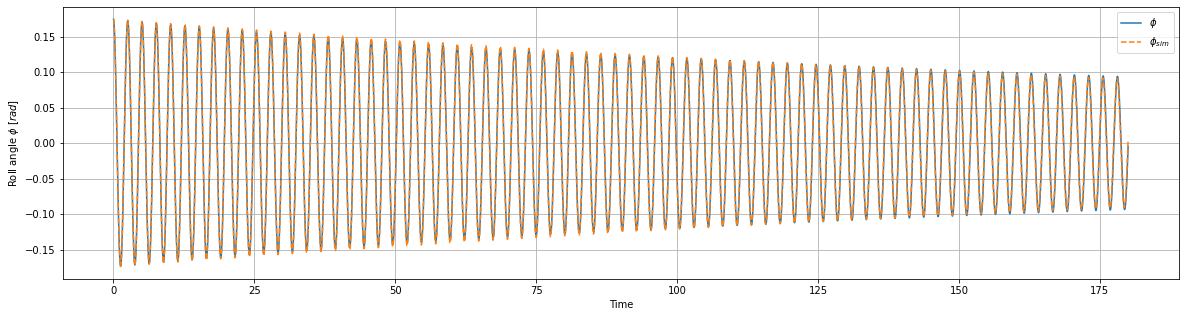

In [23]:
updater = get_updater(results=results2, calculate_features=calculate_features_simple)
result2 = solve_ivp(fun=updater, t_span=t_span, y0=y0, t_eval=t)
df_result2 = pd.DataFrame(index=result2.t, data=result2.y.T, columns = ['phi','phi1d'])

fig,ax=plt.subplots()
fig.set_size_inches(20,5)
data.plot(y='phi', ax=ax, label=r'$\phi$');

df_result2.plot(y='phi', style='--', label=r'$\phi_{sim}$', ax=ax)

ax.set_ylabel(r'Roll angle $\phi$ $[rad]$')

ax.grid(True)
ax.legend();

In [24]:
r2_score(y_true=data['phi'], y_pred=df_result2['phi'])

0.9975731060981493

So it seems that using only linear damping for this case should be sufficient, but what about the stiffness coefficients $C_1$, $C_3$ and $C_5$ cam they also be reduced to only the linear term $C_1$?

## Even simpler model

In [25]:
acceleration_equation_linear_linear = acceleration_equation_cubic.subs([
    (B_2,0),
    (B_3,0),
    (C_3,0),
    (C_5,0),
    
])

Math(vlatex(acceleration_equation_linear_linear))

<IPython.core.display.Math object>

In [26]:
def calculate_features_super_simple(data):

    phi=data['phi']
    phi1d=data['phi1d']
    data_features = -np.array([phi1d, phi]).T
    return data_features

X3,y3 = generate_features_and_label(data=data, calculate_features=calculate_features_super_simple, columns = ['B_1','C_1'])

In [27]:
model3 = sm.OLS(y3,X3)
results3 = model3.fit()

In [28]:
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  phi2d   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.815e+08
Date:                Mon, 31 May 2021   Prob (F-statistic):                        0.00
Time:                        13:47:13   Log-Likelihood:                          40218.
No. Observations:                9000   AIC:                                 -8.043e+04
Df Residuals:                    8998   BIC:                                 -8.042e+04
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
B_1            0.0072      0.000     55.819      0.000       0.007       0.007
C_1            6.1007      0.000   1.91e+04      0.000       6.100       6.101
==============================================================================
Omnibus:                     1423.706   Durbin-Watson:                   0.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26669.321
Skew:                          -0.012   Prob(JB):                         0.00
Kurtosis:                      11.433   Cond. No.                         2.47
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

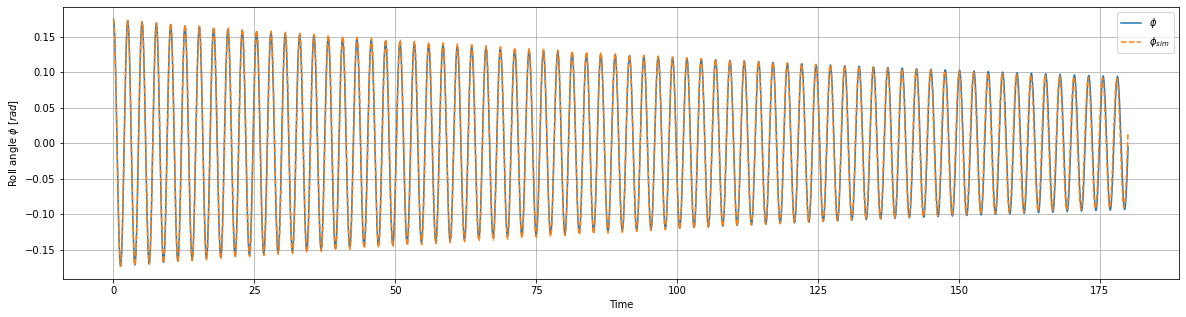

In [29]:
updater = get_updater(results=results3, calculate_features=calculate_features_super_simple)
result3 = solve_ivp(fun=updater, t_span=t_span, y0=y0, t_eval=t)
df_result3 = pd.DataFrame(index=result3.t, data=result3.y.T, columns = ['phi','phi1d'])

fig,ax=plt.subplots()
fig.set_size_inches(20,5)
data.plot(y='phi', ax=ax, label=r'$\phi$');

df_result3.plot(y='phi', style='--', label=r'$\phi_{sim}$', ax=ax)

ax.set_ylabel(r'Roll angle $\phi$ $[rad]$')

ax.grid(True)
ax.legend();

In [30]:
r2_score(y_true=data['phi'], y_pred=df_result3['phi'])

0.9885901741738339

Omitting the higher order stiffness terms $C_3$ and $C_5$ reduced the accuracy of the model, having a slightly lower $R^2$ value. The accuracy is however still quite good for this case.

In [31]:
data_all = X.copy()
data_all['phi2d'] = y
data_all.corr()

,B_1,B_2,B_3,C_1,C_3,C_5,phi2d
B_1,1.000000,0.966042,0.900191,-0.004114,-0.003985,-0.003902,-0.001187
B_2,0.966042,1.000000,0.980341,-0.003393,-0.002864,-0.002486,-0.000629
B_3,0.900191,0.980341,1.000000,-0.002892,-0.002180,-0.001702,-0.000342
C_1,-0.004114,-0.003393,-0.002892,1.000000,0.900471,0.757433,0.999984
C_3,-0.003985,-0.002864,-0.002180,0.900471,1.000000,0.957405,0.901498
C_5,-0.003902,-0.002486,-0.001702,0.757433,0.957405,1.000000,0.759281
phi2d,-0.001187,-0.000629,-0.000342,0.999984,0.901498,0.759281,1.000000


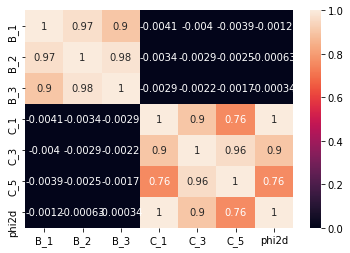

In [32]:
ax = sns.heatmap(data_all.corr(), vmin=0, vmax=1, annot=True)

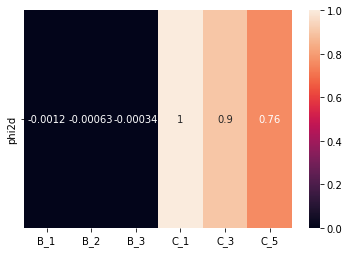

In [33]:
corr_row = data_all.corr().loc[['phi2d']]
corr_row.drop(columns='phi2d', inplace=True)
ax = sns.heatmap(corr_row, vmin=0, vmax=1, annot=True)

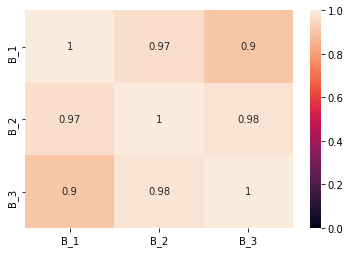

In [34]:
ax = sns.heatmap(data_all[['B_1','B_2','B_3']].corr(), vmin=0, vmax=1, annot=True)

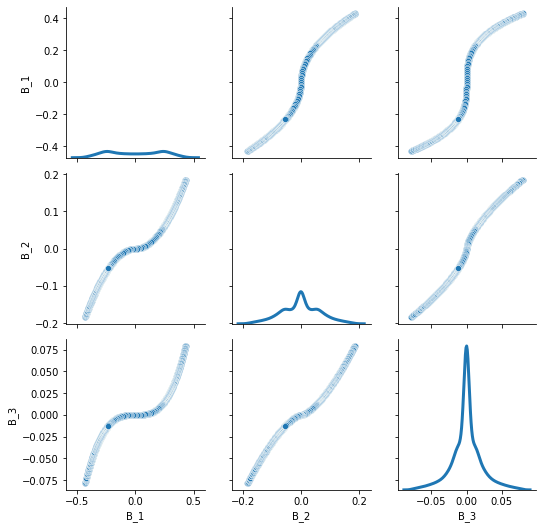

In [35]:
g = sns.PairGrid(data_all[['B_1','B_2','B_3']])
g.map_upper(sns.scatterplot)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)

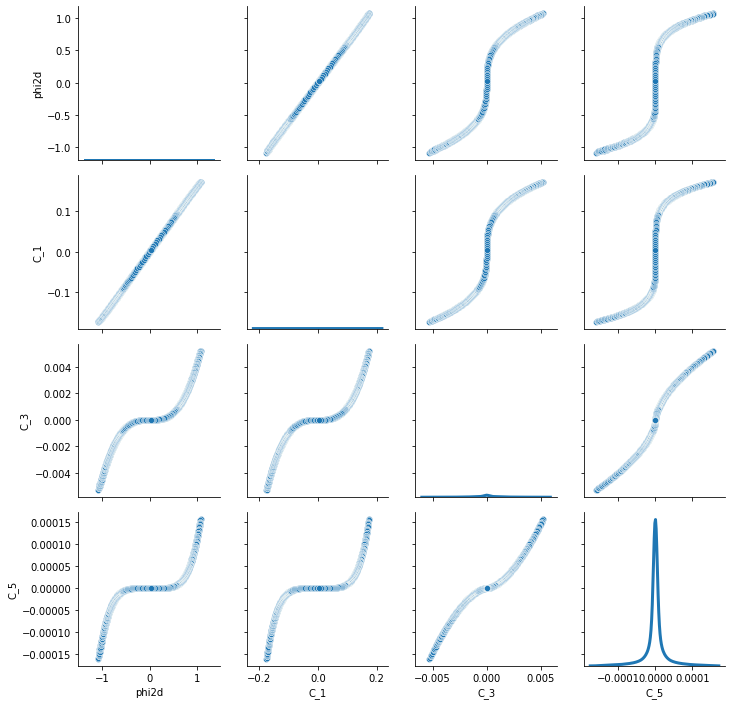

In [36]:
g = sns.PairGrid(data_all[['phi2d','C_1','C_3','C_5']])
g.map_upper(sns.scatterplot)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3, legend=False)